In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from os.path import join
from tqdm import tqdm
import os

bkg_data_path = r"/mnt/D/estagio_lip/estagio_lip_1/FCNC/Archive/New_Data/dileptonic"
signal_data_path = r"/mnt/D/estagio_lip/estagio_lip_1/FCNC/Archive/New_Data/signal"

## TO DO
* Pre-Processamento dos dados
    + Remover colunas que não interessam
    + Juntar todos os background e sinal no mesmo ficheiro .h5
    + Calcular weights
    + Criar novas colunas informativas
        + Nome do ficheiro -> "Name"
        + Dizer se é sinal ou background -> "Label" (Sinal 1, bkgd 0)
    + Cortes
        + Pelo menos 2 leptões
        + Pelo menos 1 B - Tag

## BKGD & Signal Cleanup 

In [2]:
def PreprocessData(paths, key):

    to_remove = ['gen_decay1', 'gen_decay2', 'gen_sample',
       'gen_decay_filter', 'gen_filter', 'FatJet_Multi','MissingET_Eta'] #Adicionei FatJet_Multi pois esta em signal e nao em bkgd

    print("\n\n[Info] Started preprocessing ", key, " data\n")

    data = []
    stats = [0,0] # Linhas iniciais, linhas finais
    for path in tqdm(paths, total=len(paths), desc="Processing..."):

        # Ler ficheiro atual
        current_data = pd.read_csv(path, index_col=0)

        ## Definir novas colunas
        # Nome
        current_data["Name"] = os.path.basename(path)
        # Weight
        current_data["gen_xsec"] = current_data["gen_xsec"].mean() / current_data.shape[0]
        current_data.rename(columns={"gen_xsec":"Weights"}, inplace=True)
        # Label
        if "signal" in path:
            current_data["Label"] = 1
        else:
            current_data["Label"] = 0

        # Remover colunas
        for x in to_remove:
            try:
                current_data.drop([x], axis=1, inplace=True)
            except:
                pass

        # Add to stats
        stats[0] += current_data.shape[0]
        
        ## Apply Cuts
        # Pelo menos 2 leptões
        current_data = current_data[(current_data['Electron_Multi'] + current_data['Muon_Multi']) >= 2] 
        # Pelo menos 1 B-Tag
        current_data = current_data[(current_data['Jet1_BTag'] + current_data['Jet2_BTag'] + current_data['Jet3_BTag'] + current_data['Jet4_BTag'] + current_data['Jet5_BTag']) >= 1]

        # Add to stats
        stats[1] += current_data.shape[0] 
        
        # Append data
        data.append(current_data)

        del current_data

        print("\n\n[Info] Data Reduction for ",os.path.basename(path), "-", key, ":", ((stats[0]-stats[1])/stats[0])*100, "%\n")
                                                                                        
                                        
    # Dump Data
    try: 
        data = pd.concat(data)
    except: 
        data = data[0]

    data.to_hdf(
                    join(os.getcwd(),'Data.h5'),
                    key=key
                    )


In [3]:
# Preprocess bkgd
PreprocessData(glob.glob(join(bkg_data_path, "*.csv")), 'bkgd')

# Preprocess signal
PreprocessData(glob.glob(join(signal_data_path, "*.csv")), 'signal')

Processing...:   0%|          | 0/18 [00:00<?, ?it/s]

[Info] Started preprocessing  bkgd  data

Processing...:   6%|▌         | 1/18 [00:00<00:11,  1.45it/s]

[Info] Data Reduction for  topWZ_2L.csv - bkgd : 62.626000000000005 %

Processing...:  11%|█         | 2/18 [00:01<00:14,  1.11it/s]

[Info] Data Reduction for  topZj_2L.csv - bkgd : 67.06666666666666 %

Processing...:  17%|█▋        | 3/18 [00:02<00:10,  1.40it/s]

[Info] Data Reduction for  topZj_2L_test.csv - bkgd : 67.6575 %

Processing...:  22%|██▏       | 4/18 [00:02<00:09,  1.51it/s]

[Info] Data Reduction for  topZj_2L_train.csv - bkgd : 67.9548 %

Processing...:  28%|██▊       | 5/18 [00:51<03:55, 18.12s/it]

[Info] Data Reduction for  ttbarb_2L.csv - bkgd : 68.93208889929852 %

Processing...:  33%|███▎      | 6/18 [01:00<02:58, 14.87s/it]

[Info] Data Reduction for  ttbarH_2L.csv - bkgd : 69.02392882235029 %

Processing...:  39%|███▉      | 7/18 [01:50<04:48, 26.22s/it]

[Info] Data Reduction for  ttbarj_2L.csv - bkgd 

# Plot the data!

In [4]:
import matplotlib.pyplot as plt
import mplhep as hep

bkgd_data = pd.read_hdf(
                    join(os.getcwd(),'Data.h5')
                    , key='bkgd'
                    )

signal_data = pd.read_hdf(
                    join(os.getcwd(),'Data.h5')
                    , key='signal'
                    )


Processing...: 100%|██████████| 68/68 [00:04<00:00, 13.95it/s]


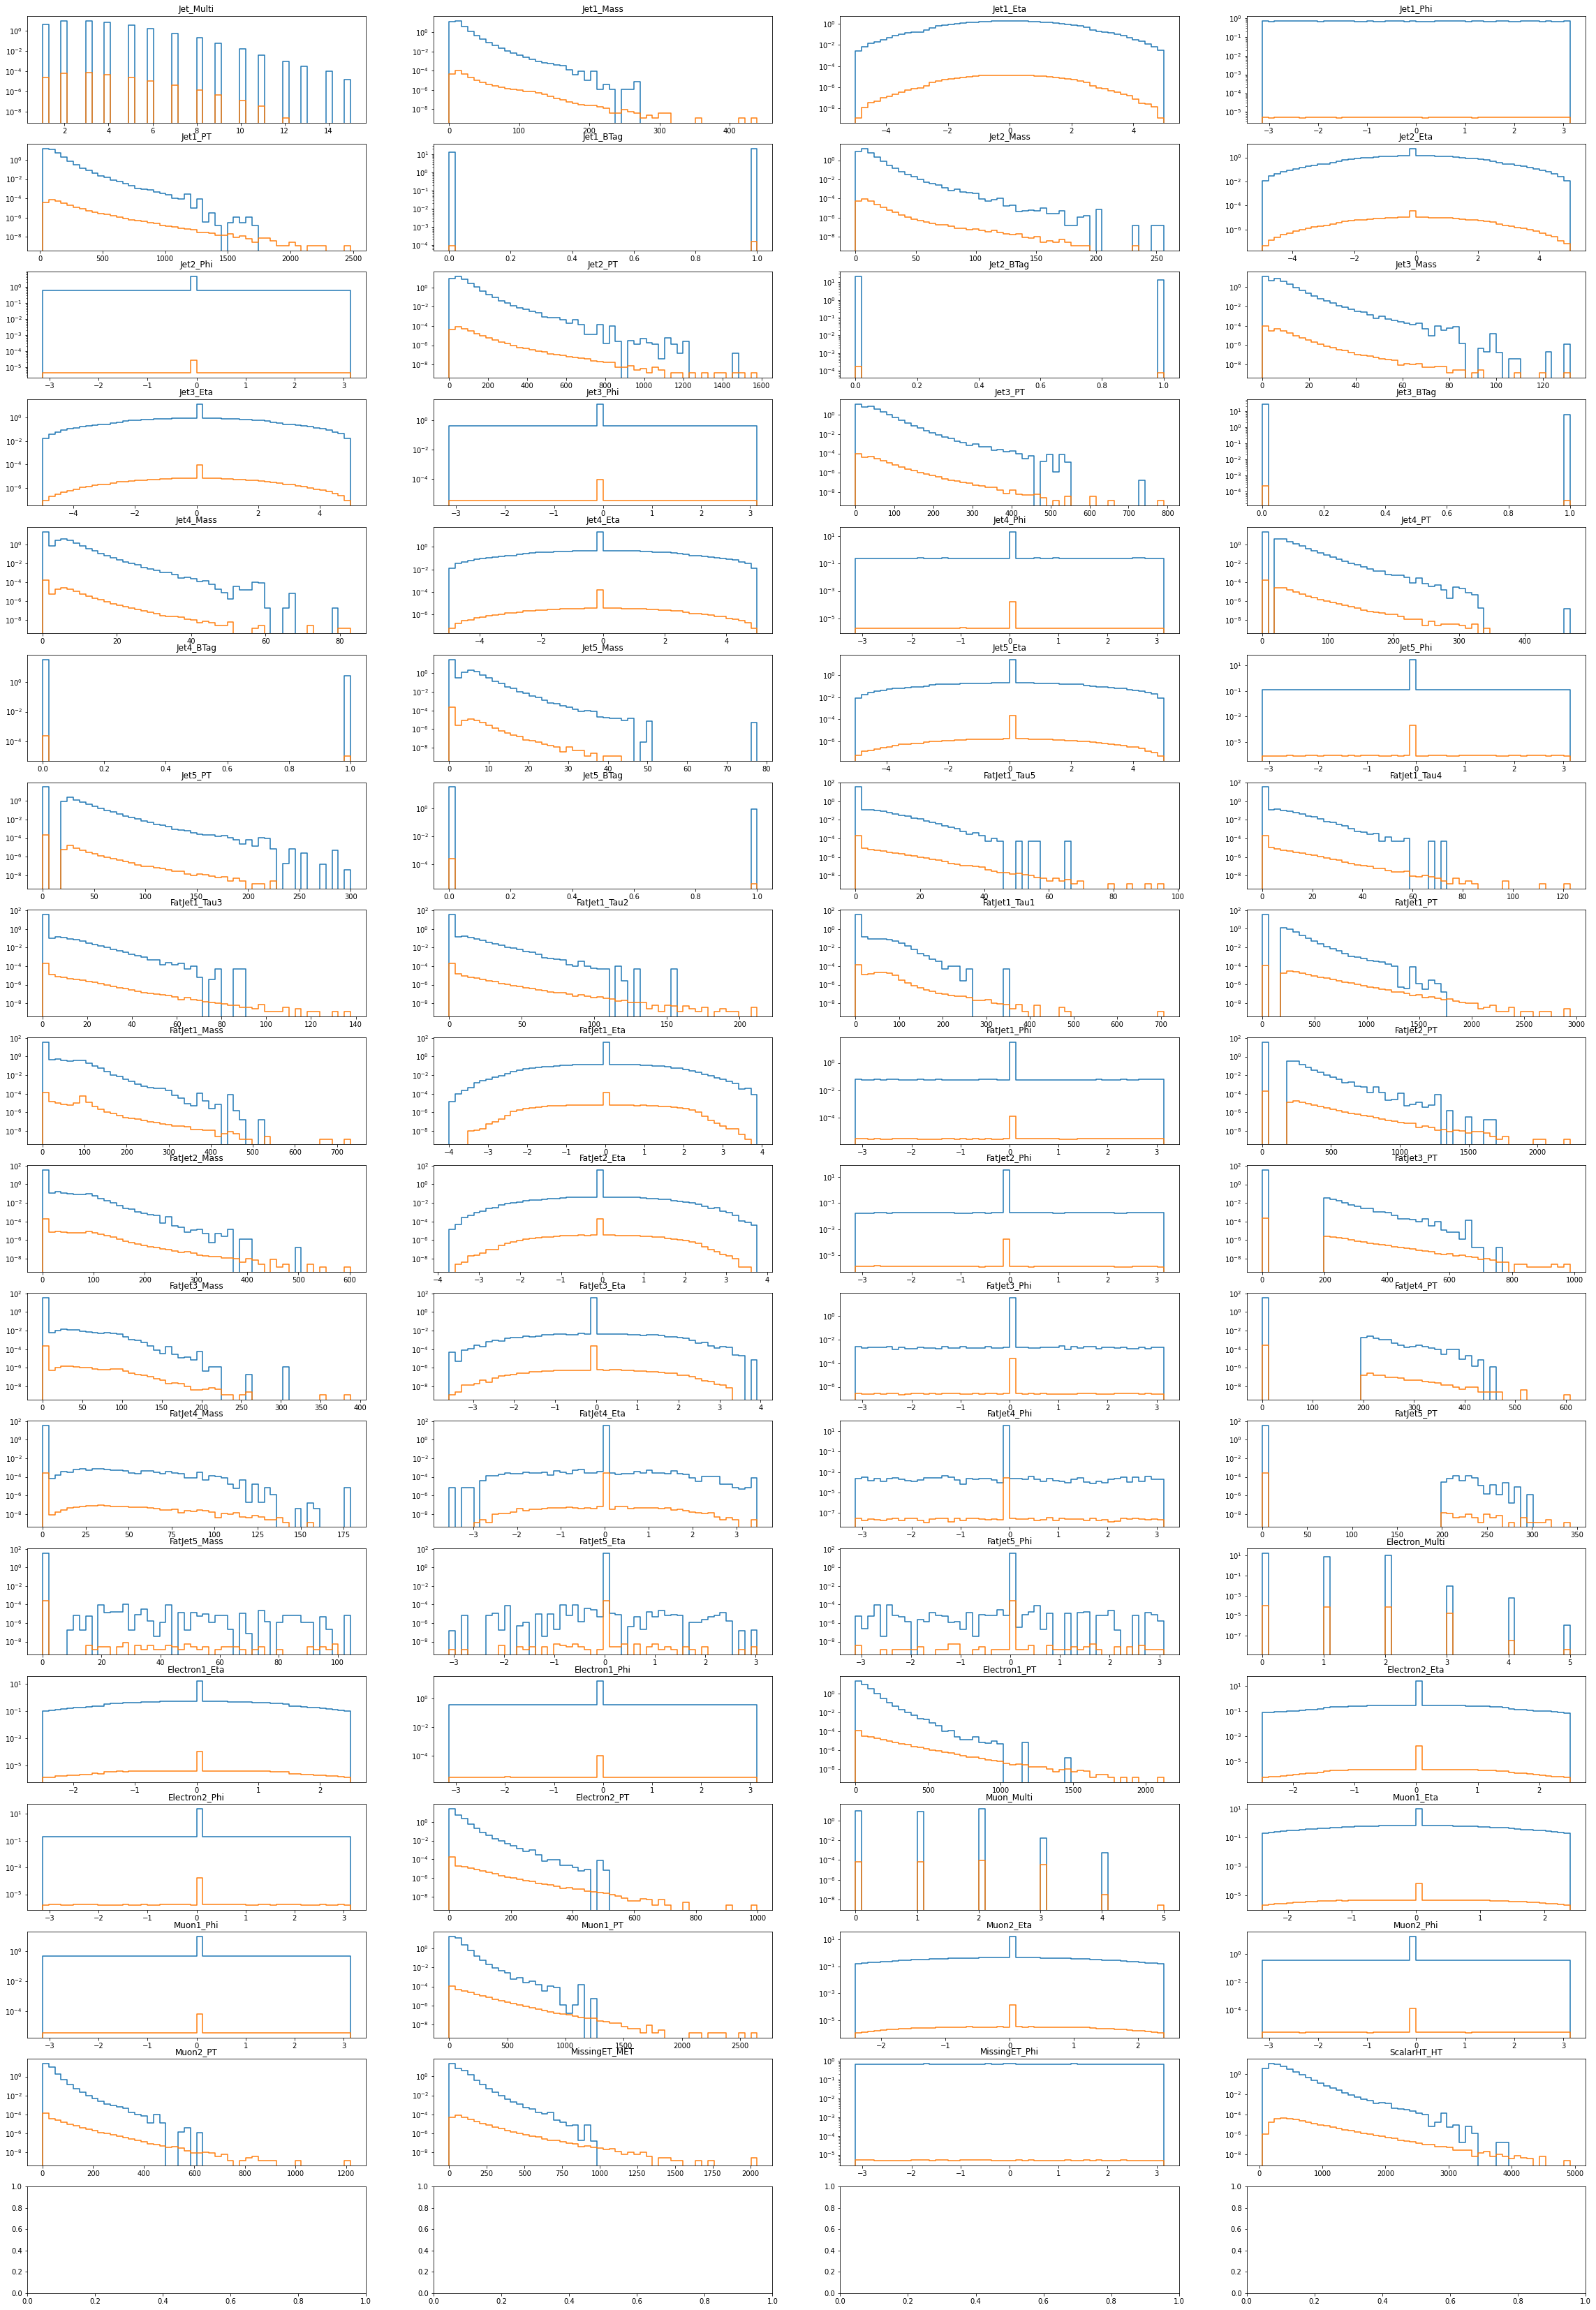

In [5]:
def PlotGraphs(bkgd, signal, bins=50, num_cols=4):

    # Criar os plots
    num_rows = int(np.ceil((len(list(signal.columns)) - 1) / num_cols))
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    colunas = list(signal.columns)
    for x in ['Name', 'Label', 'Weights']: # Remover colunas sem dados
        colunas.remove(x)

    for x in tqdm(colunas, total=len(colunas), desc="Processing..."):
        try:
            # Plot
            
            row, col = int(i/num_cols), i%num_cols
            #print("\n\n", row, col, i)
            i +=1
            

            hist_min = min(signal[x].min(), bkgd[x].min())
            hist_max = max(signal[x].max(), bkgd[x].max())
            hist_range = (hist_min, hist_max)

            axs[row, col].set_yscale('log')
            axs[row, col].set_title(x)
            axs[row, col].autoscale(enable=True)

            H1 = np.histogram(bkgd[x], bins=50, weights=bkgd['Weights'], range=hist_range)
            H2 = np.histogram(signal[x], bins=50, weights=signal['Weights'], range=hist_range)

            hep.histplot([H1, H2], ax=axs[row, col], label=['bkgd', 'signal'])
        except Exception as e:
            print("\n\n[@] ERRO:\n", e)




PlotGraphs(bkgd_data, signal_data)

# Data Normalization

### Loading the data

In [1]:
import pandas as pd 
import os
from os.path import join


# Load data
data = pd.concat([pd.read_hdf(
                    join(os.getcwd(),'Data.h5')
                    , key='signal'
                    ),
                    pd.read_hdf(
                    join(os.getcwd(),'Data.h5')
                    , key='bkgd')])

In [2]:
data['Label'].eq(0).sum(), data['Label'].eq(1).sum()

(4245075, 195725)

### Split the Data

    33% - train set,
    33% - validation set,
    33% - test set

for keeping the statistical distribution


In [3]:
# data.sample(frac=1, random_state=42) -> Shuffles dataset
# 
# Split the data
import numpy as np

traindf, validatedf, testdf = \
              np.split(data.sample(frac=1, random_state=42), 
                       [int(0.33*len(data)), int(0.66*len(data))]) 

del data

# Train df
LabelOriginal_Train = traindf['Label']
WeigthsOriginal_Train = traindf['Weights']
NameOriginal_Train = traindf['Name']
traindf.drop(['Label', 'Weights', 'Name'], axis=1, inplace=True)

# Validation
LabelOriginal_Val = validatedf['Label']
WeigthsOriginal_Val = validatedf['Weights']
NameOriginal_Val = validatedf['Name']
validatedf.drop(['Label', 'Weights', 'Name'], axis=1, inplace=True)

# Test
LabelOriginal_Test = testdf['Label']
WeigthsOriginal_Test = testdf['Weights']
NameOriginal_Test = testdf['Name']
testdf.drop(['Label', 'Weights', 'Name'], axis=1, inplace=True)

### Q Test

In [4]:
traindf.shape, validatedf.shape, testdf.shape

((1465464, 68), (1465464, 68), (1509872, 68))

In [5]:
(LabelOriginal_Train.eq(0).sum(), LabelOriginal_Train.eq(1).sum()), ( LabelOriginal_Val.eq(0).sum(), LabelOriginal_Val.eq(1).sum()), (LabelOriginal_Test.eq(0).sum(), LabelOriginal_Test.eq(1).sum())

((1400953, 64511), (1400828, 64636), (1443294, 66578))

### Normalizing the data 
row = (row - mean) / std

In [6]:
train_mean = traindf.mean()
train_std = traindf.std()

traindf = (traindf-train_mean)/train_std
validatedf = (validatedf-train_mean)/train_std
testdf = (testdf-train_mean)/train_std

traindf = pd.concat([traindf, LabelOriginal_Train, WeigthsOriginal_Train, NameOriginal_Train], axis=1)
validatedf = pd.concat([validatedf, LabelOriginal_Val, WeigthsOriginal_Val, NameOriginal_Val], axis=1)
testdf = pd.concat([testdf, LabelOriginal_Test, WeigthsOriginal_Test, NameOriginal_Test], axis=1)


In [7]:
traindf['Label'].eq(1).sum(), validatedf['Label'].eq(1).sum(), testdf['Label'].eq(1).sum()

(64511, 64636, 66578)

In [8]:
traindf['Label'].eq(0).sum(), validatedf['Label'].eq(0).sum(), testdf['Label'].eq(0).sum()

(1400953, 1400828, 1443294)

### Reset index for added professionalism 

In [9]:
testdf.reset_index(inplace=True)
validatedf.reset_index(inplace=True)
traindf.reset_index(inplace=True)

In [10]:
traindf.to_hdf(
                    join(os.getcwd(),'NormalizedData.h5'),
                    key='train'
                    )

validatedf.to_hdf(
                    join(os.getcwd(),'NormalizedData.h5'),
                    key='validate'
                    )

testdf.to_hdf(
                    join(os.getcwd(),'NormalizedData.h5'),
                    key='test'
                    )